In [13]:
#Import required function
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import matplotlib.pyplot as plt
%matplotlib notebook

Create simple time-series with 3 frequency peaks then bandpass filer it to leave a single frequency.

<IPython.core.display.Javascript object>


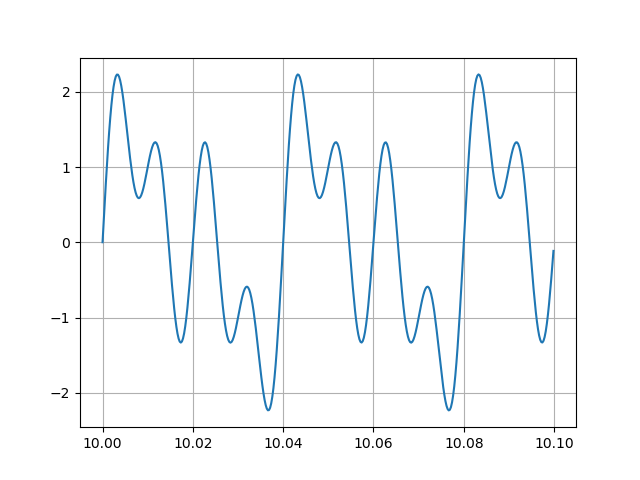

<IPython.core.display.Javascript object>


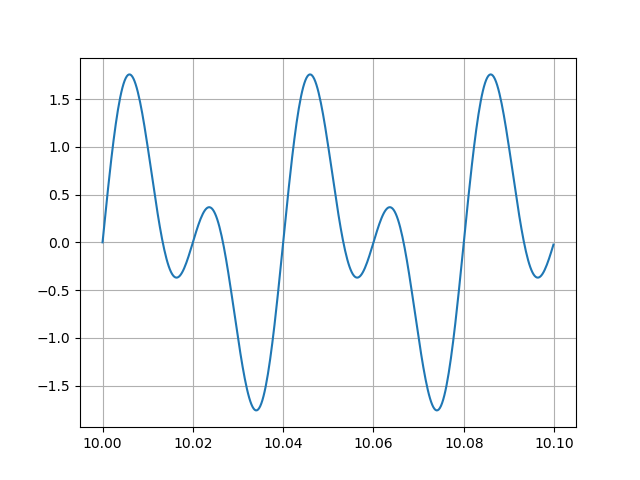

In [35]:
def lh_filter(f, tsize, fs, beta, data, ftype):
    nsamples = 2*int(tsize*fs)
    ts = np.linspace(-tsize, tsize, num=nsamples)
    tfilter = np.kaiser(nsamples, beta)*np.sinc(2*f*ts)*2*f
    ffreqs = np.fft.rfftfreq(nsamples, 1./fs)
    ffilter0 = np.fft.rfft(tfilter)
    ffilter1 = (ffilter0*np.conj(ffilter0))**0.5
    if ftype == 'low':
        ffilter = ffilter1/max(ffilter1)
    elif ftype == 'high':
        ffilter = 1 - ffilter1/max(ffilter1)
    else:
        print('ftype must be low or high, assuming low')
        ffilter = ffilter1/max(ffilter1)
    ffilteri = interp1d(ffreqs, ffilter, bounds_error=False, fill_value=0)
    dfreqs = np.fft.rfftfreq(len(data), 1./fs)
    dataft = np.fft.rfft(data)
    dataft_filtered = dataft*ffilteri(dfreqs)
    data_filtered = np.fft.irfft(dataft_filtered)
    return data_filtered


def band_filter(flow, fhigh, tsize, fs, beta, data, ftype):
    nsamples = 2*int(tsize*fs)
    ts = np.linspace(-tsize, tsize, num=nsamples)
    tfilter = np.kaiser(nsamples, beta)*(np.sinc(2*fhigh*ts)*2*fhigh - np.sinc(2*flow*ts)*2*flow)
    ffreqs = np.fft.rfftfreq(nsamples, 1./fs)
    ffilter0 = np.fft.rfft(tfilter)
    ffilter1 = (ffilter0*np.conj(ffilter0))**0.5
    if ftype == 'band':
        ffilter = ffilter1/max(ffilter1)
    elif ftype == 'notch':
        ffilter = 1 - ffilter1/max(ffilter1)
    else:
        print('ftype must be band or notch, assuming band')
        ffilter = ffilter1/max(ffilter1)
    ffilteri = interp1d(ffreqs, ffilter, bounds_error=False, fill_value=0)
    dfreqs = np.fft.rfftfreq(len(data), 1./fs)
    dataft = np.fft.rfft(data)
    dataft_filtered = dataft*ffilteri(dfreqs)
    data_filtered = np.fft.irfft(dataft_filtered)
    return data_filtered
    

fs = 4096

t = np.linspace(0, 1000, num=1000*fs)
s = np.sin(2*np.pi*t*25) + np.sin(2*np.pi*t*50) + np.sin(2*np.pi*t*100)

plt.figure()
plt.plot(t[10*fs:10*fs+410], s[10*fs:10*fs+410])
plt.grid()

filtered = band_filter(98, 102, 0.25, fs, 5, s, 'notch')
plt.figure()
plt.plot(t[10*fs:10*fs+410], filtered[10*fs:10*fs+410])
plt.grid()

Test filter on some strain data and compare to scipy functions.

<IPython.core.display.Javascript object>


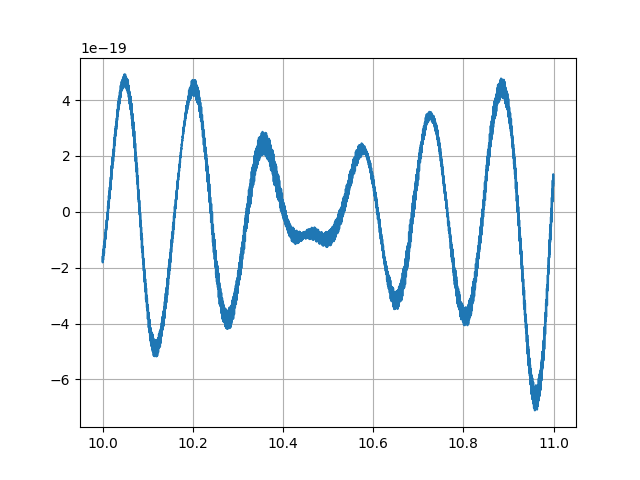

<IPython.core.display.Javascript object>


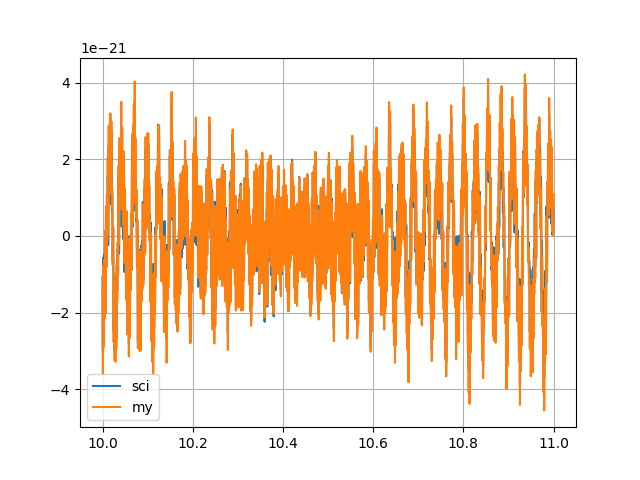

<IPython.core.display.Javascript object>


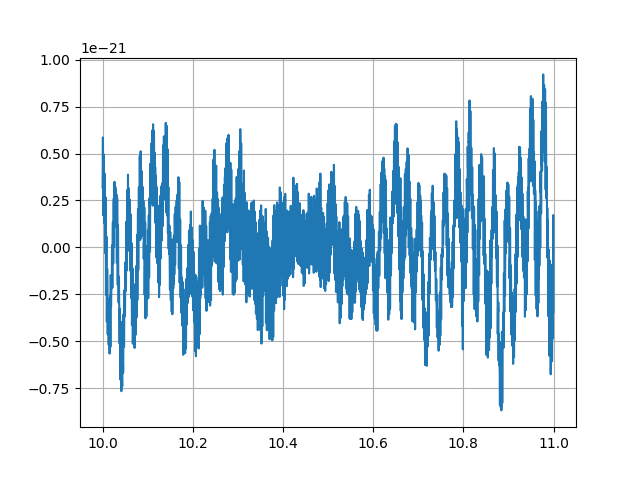

In [36]:
filename = '../Data/H-H1_LOSC_4_V1-1126076416-4096.hdf5'
f = h5py.File(filename, 'r')
strain = f['strain/Strain'][()]
dt = f['strain/Strain'].attrs['Xspacing']
tstart = f['meta/GPSstart'][()]
tend = f['meta/Duration'][()] + tstart
f.close()

low_freq = 30
high_freq = 600

bb, ab = butter(4, [low_freq*2./fs, high_freq*2./fs], btype='band')
sci_bp = filtfilt(bb, ab, strain)

my_bp = band_filter(low_freq, high_freq, 0.25, fs, 5, strain, 'band')

plt.figure()
plt.plot(t[10*fs:11*fs], strain[10*fs:11*fs])
plt.grid()

plt.figure()
plt.plot(t[10*fs:11*fs], sci_bp[10*fs:11*fs], label='sci')
plt.plot(t[10*fs:11*fs], my_bp[10*fs:11*fs], label='my')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t[10*fs:11*fs], sci_bp[10*fs:11*fs]-my_bp[10*fs:11*fs])
plt.grid()